In [29]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
import torch.nn as nn
from PIL import Image, ImageDraw
import json
import os
import random
import matplotlib.pyplot as plt

# Custom Dataset Class
class FaceRecognitionDataset(Dataset):
    def __init__(self, annotations, root_dir, transform=None):
        self.annotations = annotations
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = list(self.annotations.keys())[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        original_size = image.size
        sample_annotations = self.annotations[img_name]

        boxes = []
        names = []

        for annotation in sample_annotations:
            face_location = annotation['face_location']
            name = annotation['name']

            # Scale bounding box coordinates
            scale_x = 32.0 / original_size[0]
            scale_y = 32.0 / original_size[1]

            box_scaled = [
                int(face_location['left'] * scale_x),
                int(face_location['top'] * scale_y),
                int(face_location['right'] * scale_x),
                int(face_location['bottom'] * scale_y)
            ]

            boxes.append(box_scaled)
            names.append(name)

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Convert list of boxes to tensor
        boxes_tensor = torch.tensor(boxes, dtype=torch.float)

        return image, boxes_tensor, names


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Custom collate function for DataLoader
def collate_fn(batch):
    images = []
    all_boxes = []
    all_names = []
    for b in batch:
        images.append(b[0])
        all_boxes.append(b[1])
        all_names.append(b[2])
    images = torch.stack(images)
    return images, all_boxes, all_names

In [4]:
from google.colab import drive
drive.mount('/content/drive' ,force_remount=True)


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
from google.colab import drive
drive.mount('/content/drive' )

Mounted at /content/drive


In [32]:
# Function to partition dataset
def partition_dataset(annotations, train_frac=0.8, val_frac=0.1):
    total_samples = len(annotations)
    train_size = int(total_samples * train_frac)
    val_size = int(total_samples * val_frac)
    test_size = total_samples - train_size - val_size

    keys = list(annotations.keys())
    random.shuffle(keys)
    train_keys = keys[:train_size]
    val_keys = keys[train_size:train_size + val_size]
    test_keys = keys[train_size + val_size:]

    train_annotations = {k: annotations[k] for k in train_keys}
    val_annotations = {k: annotations[k] for k in val_keys}
    test_annotations = {k: annotations[k] for k in test_keys}

    print(f"Dataset partitioned into {len(train_annotations)} training, {len(val_annotations)} validation, and {len(test_annotations)} test samples.")

    return train_annotations, val_annotations, test_annotations

In [38]:
# Load Annotations
annotations_path = '/content/drive/MyDrive/annotations.json'  # Replace with your actual annotations file path
with open(annotations_path) as f:
    annotations = json.load(f)

# Partition the dataset into training, validation, and test sets
train_annotations, val_annotations, test_annotations = partition_dataset(annotations)


# Initialize Dataset and Dataloader
root_dir = '/content/drive/MyDrive/Face Detection Image/dataset'  # Replace with your actual images directory path

Dataset partitioned into 160 training, 20 validation, and 20 test samples.


In [39]:
# Transforms for training, validation and test datasets
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define datasets
train_dataset = FaceRecognitionDataset(train_annotations, root_dir, transform=train_transform)
val_dataset = FaceRecognitionDataset(val_annotations, root_dir, transform=val_test_transform)
test_dataset = FaceRecognitionDataset(test_annotations, root_dir, transform=val_test_transform)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [40]:
# Define the inv_normalize transform if you need to visualize images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# VGG11 Model (not used for visualization, provided for completeness)
model = models.vgg11(pretrained=False)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 128)

# Loss function and Optimizer (not used for visualization, provided for completeness)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Visualization of images with bounding boxes and names
def show_image_with_boxes(image, boxes, names):
    draw = ImageDraw.Draw(image)
    for box, name in zip(boxes, names):
        # Draw bounding box and name
        draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline="red", width=2)
        draw.text((box[0], box[1] - 10), name, fill="red")
    return image

Visualizing the first sample from the first mini-batch...


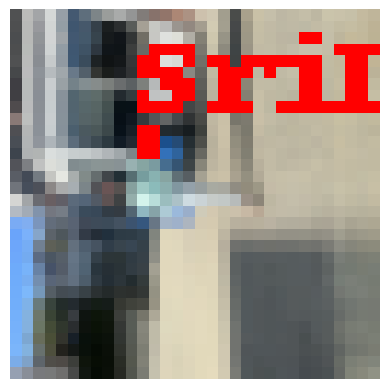

In [41]:
# Get the first batch from the train loader
first_batch_images, first_batch_boxes, first_batch_names = next(iter(train_loader))

# Apply inverse normalization to the first image in the first batch
first_image = inv_normalize(first_batch_images[0]).clamp(0, 1)
first_image_pil = transforms.ToPILImage()(first_image)

# Visualize the first sample from the first mini-batch
print("Visualizing the first sample from the first mini-batch...")
first_image_with_boxes = show_image_with_boxes(first_image_pil, first_batch_boxes[0], first_batch_names[0])
plt.imshow(first_image_with_boxes)
plt.axis('off')
plt.show()


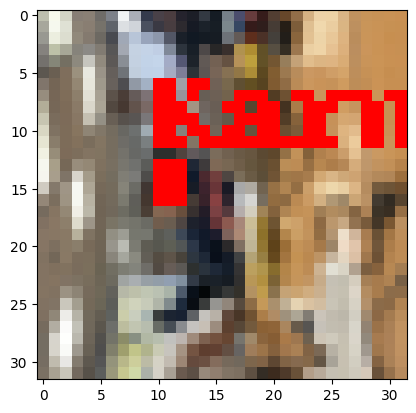

In [42]:
for batch in train_loader:
  images, boxes, labels = batch
  for i in range(len(batch)):
    img = inv_normalize(images[i]).clamp(0,1)
    image_pil = transforms.ToPILImage()(img)
    image_with_boxes = show_image_with_boxes(image_pil, boxes[i], labels[i])
    plt.imshow(image_with_boxes)

In [43]:
vgg16 = models.vgg16(pretrained = True)
vgg16 = vgg16.features

for param in vgg16.parameters():
  param.requires_grad = False

In [44]:
model = nn.Sequential(
    vgg16,
    nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 4)
)
momentum_coefficient = 0.9
weight_decay = 0.0001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, betas=(momentum_coefficient, 0.999), weight_decay=0.0001)

In [45]:
# Training
EPOCHS = 50
losses = []
for epoch in range(EPOCHS):
  model.train()
  total_loss = 0.0

  for batch in train_loader:
    image, bounding_box, _ = batch
    num_boxes = batch[0].size(0)
    optimizer.zero_grad()
    outputs = model(image)
    outputs = outputs.view(-1, num_boxes, 4)
    #bounding_box = np.array(bounding_box)
    for i in range(len(bounding_box)):
      if bounding_box[i].numel() == 0:
        #bounding_box[i] = torch.empty(1,4)
        bounding_box[i] = torch.randint(0, 300, (1,4))
      elif bounding_box[i].shape != torch.Size([1, 4]):
        bounding_box[i] = bounding_box[i][:1]


    bounding_box = torch.stack(bounding_box)
    loss = criterion(outputs, bounding_box)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  average_loss = total_loss/len(train_loader)
  losses.append(average_loss)
  print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {average_loss: .4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1, 4])) that is different to the input size (torch.Size([1, 8, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Loss:  367.4195
Epoch [2/50], Loss:  383.2997
Epoch [3/50], Loss:  429.9602
Epoch [4/50], Loss:  534.3870
Epoch [5/50], Loss:  417.0169
Epoch [6/50], Loss:  206.2862
Epoch [7/50], Loss:  495.7416
Epoch [8/50], Loss:  269.7370
Epoch [9/50], Loss:  283.3172
Epoch [10/50], Loss:  412.5321
Epoch [11/50], Loss:  283.2002
Epoch [12/50], Loss:  265.6735
Epoch [13/50], Loss:  556.2665
Epoch [14/50], Loss:  296.4450
Epoch [15/50], Loss:  235.5942
Epoch [16/50], Loss:  515.8145
Epoch [17/50], Loss:  301.8787
Epoch [18/50], Loss:  362.2013
Epoch [19/50], Loss:  230.1154
Epoch [20/50], Loss:  355.5418
Epoch [21/50], Loss:  335.6764
Epoch [22/50], Loss:  408.6685
Epoch [23/50], Loss:  301.5100
Epoch [24/50], Loss:  360.0477
Epoch [25/50], Loss:  255.7336
Epoch [26/50], Loss:  320.5666
Epoch [27/50], Loss:  433.3484
Epoch [28/50], Loss:  246.8522
Epoch [29/50], Loss:  568.0133
Epoch [30/50], Loss:  292.8584
Epoch [31/50], Loss:  293.3492
Epoch [32/50], Loss:  284.5725
Epoch [33/50], Lo

Text(0, 0.5, 'Loss')

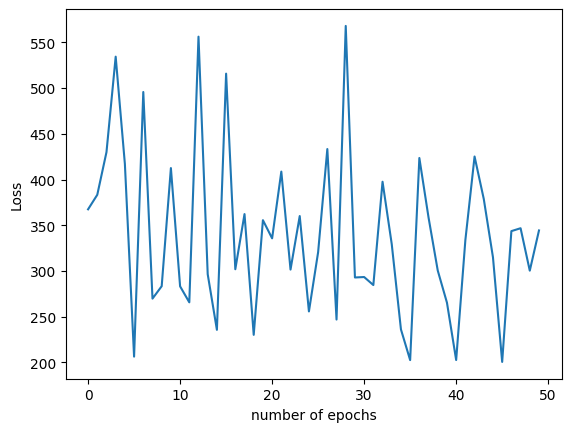

In [46]:
plt.plot(range(0, EPOCHS), losses)
plt.xlabel('number of epochs')
plt.ylabel('Loss')

In [47]:
model.eval()
total_loss_val = 0.0

with torch.no_grad():
    for inputs, bounding_boxes,_ in val_loader:
        outputs = model(inputs)
        #outputs = outputs.view(-1, num_boxes, 4)
        #bounding_box = np.array(bounding_box)
        for i in range(len(bounding_boxes)):
          if bounding_boxes[i].numel() == 0:
            bounding_boxes[i] = torch.randint(0, 300, (1,4))
          elif bounding_boxes[i].shape != torch.Size([1, 4]):
            bounding_boxes[i] = bounding_boxes[i][:1]

        bounding_boxes = torch.stack(bounding_boxes)
        loss = criterion(outputs, bounding_boxes)
        total_loss_val += loss.item()

    average_loss_val = total_loss_val / len(val_loader)
    print(f"Average Evaluation Loss: {average_loss_val:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1, 4])) that is different to the input size (torch.Size([8, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Evaluation Loss: 127.5735


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Visualizing the first sample from the first mini-batch...


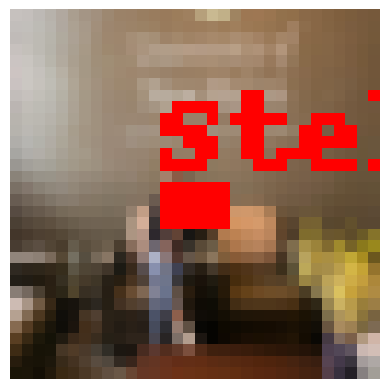

In [48]:
# Get the first batch from the train loader
first_batch_images, first_batch_boxes, first_batch_names = next(iter(test_loader))

# Apply inverse normalization to the first image in the first batch
first_image = inv_normalize(first_batch_images[1]).clamp(0, 1)
first_image_pil = transforms.ToPILImage()(first_image)

# Visualize the first sample from the first mini-batch
print("Visualizing the first sample from the first mini-batch...")
first_image_with_boxes = show_image_with_boxes(first_image_pil, first_batch_boxes[0], first_batch_names[0])
plt.imshow(first_image_with_boxes)
plt.axis('off')
plt.show()

In [49]:
output_test = model(first_batch_images)

In [50]:
import numpy as np
output_test[1]

tensor([20.2915, 13.6342, 23.4888, 17.6738], grad_fn=<SelectBackward0>)

In [51]:
output = torch.tensor([[13.3988,  8.9850, 16.9358, 12.3490]])

In [52]:
first_batch_boxes[1]

tensor([[13., 13., 15., 15.]])

Visualizing the first sample from the first mini-batch...


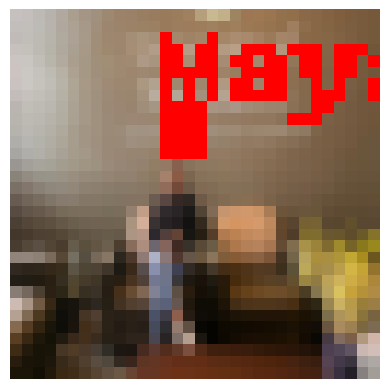

In [53]:
# Apply inverse normalization to the first image in the first batch
first_image = inv_normalize(first_batch_images[1]).clamp(0, 1)
first_image_pil = transforms.ToPILImage()(first_image)

# Visualize the first sample from the first mini-batch
print("Visualizing the first sample from the first mini-batch...")
first_image_with_boxes = show_image_with_boxes(first_image_pil, output, first_batch_names[1])
plt.imshow(first_image_with_boxes)
plt.axis('off')
plt.show()

Visualizing the first sample from the first mini-batch...


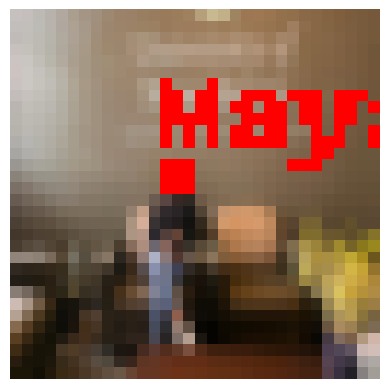

In [54]:
# Apply inverse normalization to the first image in the first batch
first_image = inv_normalize(first_batch_images[1]).clamp(0, 1)
first_image_pil = transforms.ToPILImage()(first_image)

# Visualize the first sample from the first mini-batch
print("Visualizing the first sample from the first mini-batch...")
first_image_with_boxes = show_image_with_boxes(first_image_pil, first_batch_boxes[1], first_batch_names[1])
plt.imshow(first_image_with_boxes)
plt.axis('off')
plt.show()